#### 模型选择、欠拟合和过拟合

前几节给予Fashion_MNIST数据集的实验中，我们评价了机器学习模型在训练集合测试集上的表现。通常得到的结果都是训练数据集上更准确时，它在测试集上表现不一定更好，这就涉及到了模型的选择以及拟合程度的选择。

##### 训练误差和泛化误差

- 训练误差
 是指模型在训练数据集上表现出来的误差
- 泛化误差
是指模型在任意一个测试样本上表现出的误差的期望，并通常通过测试数据集的误差来近似

##### 模型选择

从严格意义上讲，测试集只能在所有的超参数和模型参数选定后使用一次，不可以使用测试集选择模型，如调参。由于无法从训练误差估计泛化误差，因此也不应该依赖训练数据选择模型。鉴于此，我们可以预留一部分在训练数据集和测试数据集以外的数据来进行模型选择。这部分数据被称为验证数据集(validation set)。例如，我们可以从给定的训练集中随机选取一部分作为验证集，而剩余部分作为真正的训练集。

##### K折交叉验证

![](https://tva1.sinaimg.cn/large/006y8mN6gy1g8qj3yx7asj314u0meadk.jpg)

##### 欠拟合和过拟合

欠拟合：模型无法得到较低的训练误差
过拟合：模型的训练误差远小于它在测试集上的误差
讨论一下两个因素：模型复杂度和训练数据集大小

###### 模型复杂度

为了解释模型复杂度，我们以多项式函数拟合为例。给定一个由标量数据特征x和对应的标量标签y组成的训练数据集，多项式函数拟合的目标是找一个K阶多项式函数
$\hat{y} = b+ \sum_{k=1}^{K}x^{k}w_{k}$ 来近似y。在上式中，$w_{k}是模型的权重参数，b为偏置参数$。与线性回归相同，多项式函数拟合也是用平方损失函数。特别的一阶多项式函数拟合又叫做线性函数拟合。

因为告诫多项式函数模型参数更多，模型函数的选择空间更大，所以告诫多项式函数比低阶多项式函数的复杂程度高。高阶多项式函数比低阶多项式函数更容易在相同的训练集上得到更低的训练误差。给定训练集，如果模型的复杂度过低，会让你容易出现欠拟合，如果模型复杂度过高，很容易出现过拟合。**选择合适复杂度的模型可以有效应对欠拟合和过拟合**
![](https://tva1.sinaimg.cn/large/006y8mN6gy1g8qnuz2oihj30a7074q34.jpg)

###### 训练数据集大小

在计算资源允许的情况下，通常希望训练数据集大一些，特别是在模型复杂度较高的时候，例如层数较多的深度学习模型。

###### 多项式函数拟合实验

In [1]:
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

我们将生成一个人工数据集。在训练数据集和测试数据集中，给定样本特征x，我们使用如下的三阶多项式生成该样本的标签:
$y = 1.2x-3.4x^{2}+5.6x^{3}+5+\epsilon$
其中噪声项$\epsilon$服从均值为0，标准差为0.01的正态分布。
训练数据集和测试数据集的样本数都设为100。

In [2]:
n_train,n_test,true_w,true_b = 100,100,[1.2,-3.4,5.6],5
features = torch.randn((n_train+n_test,1))
ploy_features = torch.cat((features,torch.pow(features,2),torch.pow(features,3)),1)
# 组成三维tensor,与numpy中的concentrate,pandas里面的concat相似
labels = (true_w[0]*ploy_features[:,0]+true_w[1]*ploy_features[:,1]+true_w[2]*ploy_features[:,2]+true_b)
labels +=torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

In [3]:
features[:2],ploy_features[:2],labels[:2]
# 前两个样本名

(tensor([[0.0698],
         [0.8801]]), tensor([[6.9778e-02, 4.8690e-03, 3.3975e-04],
         [8.8014e-01, 7.7465e-01, 6.8180e-01]]), tensor([5.0629, 7.2319]))

###### 定义、训练和测试模型

In [4]:
#定义作图函数 semiplgy 其中y轴使用了对数尺度
def semilogy(x,y,x_label,y_label,x2=None,y2=None,legend=None,figsize=(3.5,2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x,y)
    if x2 and y2:
        d2l.plt.semilogy(x2,y2,linestyle=':')
        d2l.plt.legend(legend)
    

和线性回归一样，多项式函数拟合也是用平方损失函数，因为我们尝试使用不同的复杂度的模型来拟合生成的数据集，所以我们把模型定义部分放在fit_and_plot函数中。多项式函数拟合的训练和测试步骤与softmax回归中的步骤相似。

In [5]:
num_epochs,loss = 100,torch.nn.MSELoss()

def fit_and_plot(train_features,test_features,train_labels,test_labels):
    net = torch.nn.Linear(train_features.shape[-1],1)
    # Linear文档中lpytorch已经将参数初始化了，所以不必再手动初始化
    batch_size = min(10,train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    optimizer  = torch.optim.SGD(net.parameters(),lr =0.01)
    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y.view(-1,1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1,1)
        test_labels = test_labels.view(-1,1)
        train_ls.append(loss(net(train_features),train_labels).item())
        test_ls.append(loss(net(test_features),test_labels).item())
    print('final epoch:train loss',train_ls[-1],'test loss',test_ls[-1])
    semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',
        range(1,num_epochs+1),test_ls,['train','test'])
    print('weight',net.weight.data,
     '\nbias',net.bias.data)


final epoch:train loss 0.00012625716044567525 test loss 9.9329357908573e-05
weight tensor([[ 1.2012, -3.4010,  5.5998]]) 
bias tensor([5.0000])


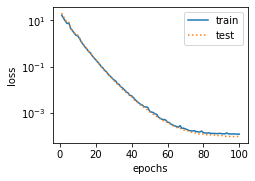

In [6]:
fit_and_plot(ploy_features[:n_train,:],ploy_features[n_train:,:],
            labels[:n_train],labels[n_train:])

###### 欠拟合

final epoch:train loss 159.88214111328125 test loss 137.93870544433594
weight tensor([[18.9767]]) 
bias tensor([3.2336])


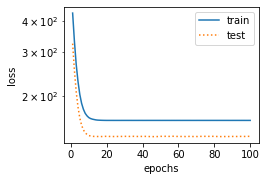

In [8]:
fit_and_plot(features[:n_train,:],features[n_train:,:],
            labels[:n_train],labels[n_train:])

###### 过拟合

final epoch:train loss 59.23940658569336 test loss 193.23995971679688
weight tensor([[12.1020]]) 
bias tensor([5.6643])


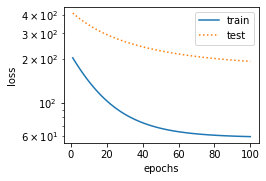

In [10]:
fit_and_plot(features[:20,:],features[n_train:,:],
            labels[0:20],labels[n_train:])

#### 小结
- 由于无法从训练误差估计泛化误差，一味地降低训练误差不一定能减低泛化误差。机器学习模型应该关注降低泛华误差。
- 可以使用验证数据集来进行模型选择
- 欠拟合是指模型无法得到较低的训练误差，过拟合是指模型的训练误差远小于他在测试集的误差。
- 应选择复杂度合适的模型并避免使用过少的训练样本，保证模型复杂度始终，训练样本足够。